In [16]:
# Create a connection

from cassandra.cluster import Cluster
try: 
    cluster = Cluster(['127.0.0.1']) #If you have a locally installed Apache Cassandra instance
    session = cluster.connect()
except Exception as e:
    print(e)

In [17]:
# Create a keyspace
try:
    session.execute("""
    CREATE KEYSPACE IF NOT EXISTS killrvideo
    WITH REPLICATION = 
    { 'class' : 'SimpleStrategy', 'replication_factor' : 1 }"""
)

except Exception as e:
    print(e)

In [18]:
# Set the keyspace
try:
    session.set_keyspace('killrvideo')
except Exception as e:
    print(e)

## Create a bad table with non-unique partition

In [33]:
query = """
CREATE TABLE IF NOT EXISTS bad_videos_by_tag_year(
    tag text,
    added_year int,
    video_id timeuuid,
    added_date timestamp,
    description text,
    title text,
    user_id uuid,
    PRIMARY KEY ((video_id))
)
"""
try:
    session.execute(query)
except Exception as e:
    print(e)

# Load data

In [34]:
import csv
import uuid
import datetime
import pandas as pd

In [35]:
file =  r'C:\Users\abdul\cassandra-fundamentals\foundations-of-apache-cassandra\data\videos_by_tag_year.csv'

In [36]:
# df = pd.read_csv(file)
# # Remove spaces from the column names
# df.columns = [column.strip() for column in df.columns]
# # drop the 
# df.drop(columns='Unnamed: 7', inplace=True)
# df['added date'] = df['added date'].str.strip()
# df.columns

In [37]:
#  f"The length of the dataframe: {df.shape[0]}"

# Lets load data

In [38]:
# df.columns

In [39]:
# df.head()

In [40]:
# df['added year'][0].dtype

In [41]:
# for index, row in df.iterrows():
#     tag = row['tag']
#     added_year = row['added year']
#     video_id = uuid.UUID(row['video id'])
#     added_date = row['added date']
#     if '/' in added_date:
#         added_date = datetime.datetime.strptime(added_date, "%m/%d/%Y")
#     else:
#         added_date = added_date
        
#         #datetime.datetime.strptime(added_date, "%Y-%m-%d %H:%M:%S%z")
#     description = row['description']
#     title = row['title']
#     user_id = uuid.UUID(row['user id'])
    
#     query = "INSERT INTO bad_videos_by_tag_year(tag, added_year, video_id, added_date, description, title, user_id)"
#     query = query + "VALUES(%s, %s, %s, %s, %s, %s, %s)"
    
#     session.execute(query, (tag, added_year, video_id, added_date, description, title, user_id))

## Create a bad table with non-unique partition

In [ ]:
query = """
CREATE TABLE IF NOT EXISTS bad_videos_by_tag_year(
    tag text,
    added_year int,
    video_id timeuuid,
    added_date timestamp,
    description text,
    title text,
    user_id uuid,
    PRIMARY KEY ((video_id))
)
"""
try:
    session.execute(query)
except Exception as e:
    print(e)

In [42]:
# Iterating through csv bringing about error in reading data along rows

file =  r'C:\Users\abdul\cassandra-fundamentals\foundations-of-apache-cassandra\data\videos_by_tag_year.csv'

with open(file, encoding="utf8") as f:
    reader = csv.reader(f)
    next(reader)
    for line in reader:
        query = "INSERT INTO bad_videos_by_tag_year(tag, added_year, video_id, added_date, description, title, user_id)"
        query = query + "VALUES(%s, %s, %s, %s, %s, %s, %s)"
        
        tag = line[0]
        added_year = int(line[1])
        video_id = uuid.UUID(line[2])
        added_date = line[3]
        if "/" in added_date:
            added_date = datetime.datetime.strptime(added_date, "%m/%d/%Y")
        else:
            added_date = datetime.datetime.strptime(added_date, "%Y-%m-%d %H:%M:%S%z") #2015-03-29 08:00:03+0000
            
        description = line[4]
        title = line[5]
        user_id= uuid.UUID(line[6])
        
        session.execute(query, (tag, added_year, video_id, added_date, description, title, user_id))

In [43]:
query = "SELECT COUNT(*) FROM bad_videos_by_tag_year"
try:
    rows = session.execute(query)
except Exception as e:
    print(e)
    
for row in rows:
    print(row)

Row(count=422)


- The number of rows is not `422` instead `797` just like what we have in the `csv` data. THis is because the primary key we used is not unique so we got duplicates of video_id data. Hence upon adding existing video_id values, the cassandra engine replace the old insert with new insert of duplicated video_id values.

To solve teh above problem, we need to make our PRIMARY KEY UNIQUE for every row in the data

In [51]:
query = """
CREATE TABLE IF NOT EXISTS videos_by_tag_year(
    tag text,
    added_year int,
    video_id timeuuid,
    added_date timestamp,
    description text,
    title text,
    user_id uuid,
    PRIMARY KEY ((tag, video_id), added_year)
)
WITH CLUSTERING ORDER BY(added_year DESC)
"""
try:
    session.execute(query)
except Exception as e:
    print(e)

In [52]:
file =  r'C:\Users\abdul\cassandra-fundamentals\foundations-of-apache-cassandra\data\videos_by_tag_year.csv'

with open(file, encoding="utf8") as f:
    reader = csv.reader(f)
    next(reader)
    for line in reader:
        query = "INSERT INTO videos_by_tag_year(tag, added_year, video_id, added_date, description, title, user_id)"
        query = query + "VALUES(%s, %s, %s, %s, %s, %s, %s)"
        
        tag = line[0]
        added_year = int(line[1])
        video_id = uuid.UUID(line[2])
        added_date = line[3]
        if "/" in added_date:
            added_date = datetime.datetime.strptime(added_date, "%m/%d/%Y")
        else:
            added_date = datetime.datetime.strptime(added_date, "%Y-%m-%d %H:%M:%S%z") #2015-03-29 08:00:03+0000
            
        description = line[4]
        title = line[5]
        user_id= uuid.UUID(line[6])
        
        session.execute(query, (tag, added_year, video_id, added_date, description, title, user_id))

In [53]:
query = "SELECT COUNT(*) FROM videos_by_tag_year"
try:
    rows = session.execute(query)
except Exception as e:
    print(e)
    
for row in rows:
    print(row)

Row(count=797)


## RUN QUERIES

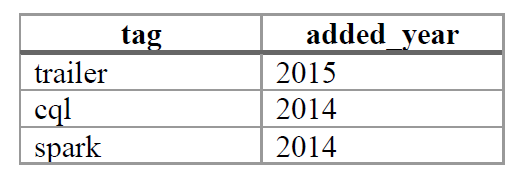

### Query 1

In [58]:
query = """
    SELECT video_id, tag, description, title
    FROM videos_by_tag_year
    WHERE tag='trailer' AND added_year=2015 ALLOW FILTERING
"""
try:
    rows = session.execute(query)
except Exception as e:
    print(e)
    
for row in rows:
    print(row.video_id, row.tag, row.description, row.title)

584bbdbc-41e5-19d4-bda2-e6f4d1ec1f4a trailer WASH Multifamily Laundry Systems is growing rapidly and using Microsoft Cloud solutions such as Azure Machine Learning and Power BI to analyze data from ... Woman in Gold Official Trailer #2 (2015) - Helen Mirren, Ryan Reynolds Movie HD
c3fa0ebe-d511-1d1a-8c97-02ff0e88957a trailer Dr. Gupta and a representative from the Make-A-Wish Foundation meet with a terminally ill boy, but the things he wants to do before he dies makes them both very uncomfortable.\n\nWatch more Key & Peele: http://on.cc.com/1wa82It Hotel Transylvania 2 Official International Teaser Trailer #1 (2015) - Animated Sequel HD
24153e4f-123d-1cbe-a767-d9a28972a31d trailer This is a crash course introduction to Cassandra. You'll step away understanding how it's possible to to utilize this distributed database to achieve high availability across multiple data centers, scale out as your needs grow, and not be woken up at 3am just because a server failed. We'll cover the basics of

### Query 2

In [59]:
query = """
    SELECT video_id, tag, description, title
    FROM videos_by_tag_year
    WHERE tag='cql' AND added_year=2014 ALLOW FILTERING
"""
try:
    rows = session.execute(query)
except Exception as e:
    print(e)
    
for row in rows:
    print(row.video_id, row.tag, row.description, row.title)

b68132a3-7a41-10b3-9d9e-f60d2acf59bd cql Speaker: J.B. Langston Company: DataStax I'll give a general lay of the land for troubleshooting Cassandra. I'll show you what to look for in the logs, what ... The Last Pickle: Lesser Known Features of Cassandra 2.0 and 2.1


### Query 3

In [60]:
query = """
    SELECT video_id, tag, description, title
    FROM videos_by_tag_year
    WHERE tag='spark' AND added_year=2014 ALLOW FILTERING
"""
try:
    rows = session.execute(query)
except Exception as e:
    print(e)
    
for row in rows:
    print(row.video_id, row.tag, row.description, row.title)

dab20eb0-e9a3-1a47-8fc2-672b8bccfbb0 spark Grumpy cat takes a nap on top of my niece. Check out our website: www.grumpycats.com New Tshirts at: ... Databricks: Apache Spark - The SDK for All Big Data Platforms 


### Try querying for all videos with tag "cql" added before the year 2015.

In [61]:
query = """
    SELECT video_id, tag, description, title
    FROM videos_by_tag_year
    WHERE tag='cql' AND added_year<2015 ALLOW FILTERING
"""
try:
    rows = session.execute(query)
except Exception as e:
    print(e)
    
for row in rows:
    print(row.video_id, row.tag, row.description, row.title)

b68132a3-7a41-10b3-9d9e-f60d2acf59bd cql Speaker: J.B. Langston Company: DataStax I'll give a general lay of the land for troubleshooting Cassandra. I'll show you what to look for in the logs, what ... The Last Pickle: Lesser Known Features of Cassandra 2.0 and 2.1


### Try querying for all videos added before 2015.

In [63]:
query = """
    SELECT video_id, tag, description, title
    FROM videos_by_tag_year
    WHERE added_year<2015
"""
try:
    rows = session.execute(query)
except Exception as e:
    print(e)
    
for row in rows:
    print(row.video_id, row.tag, row.description, row.title)

Error from server: code=2200 [Invalid query] message="Cannot execute this query as it might involve data filtering and thus may have unpredictable performance. If you want to execute this query despite the performance unpredictability, use ALLOW FILTERING"


- IF we introduce allow filtering to the above, it will work

# Drop table

In [65]:
query = "DROP TABLE IF EXISTS bad_videos_by_tag_year"
try:
    session.execute(query)
except Exception as e:
    print(e)
query = "DROP TABLE IF EXISTS videos_by_tag_year"
try:
    session.execute(query)
except Exception as e:
    print(e)